# Import bibliotek

In [1]:
import pandas as pd
import xml.etree.ElementTree as xet
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

# Załadowanie danych

In [4]:
df_copy = pd.read_csv('labels.csv')
df_copy.head()
df = df_copy
df.head(10)

,filepath,xmin,xmax,ymin,ymax
0,kaggle_dataset001/images\N1.xml,1093,1396,645,727
1,kaggle_dataset001/images\N100.xml,134,301,312,350
2,kaggle_dataset001/images\N101.xml,31,139,128,161
3,kaggle_dataset001/images\N102.xml,164,316,216,243
4,kaggle_dataset001/images\N103.xml,813,1067,665,724
5,kaggle_dataset001/images\N104.xml,66,154,166,197
6,kaggle_dataset001/images\N105.xml,360,434,174,195
7,kaggle_dataset001/images\N106.xml,137,262,249,290
8,kaggle_dataset001/images\N107.xml,207,356,174,287
9,kaggle_dataset001/images\N108.xml,184,342,220,257


Przetwarzamy dane, aby uzyskać ścieżki do plików.

In [5]:
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'kaggle_dataset001/images/{name}'
    return filename
df[['filename']] = df['filepath'].apply(parsing).apply(pd.Series)
df = df.drop('filepath', axis=1)
df.head()

,xmin,xmax,ymin,ymax,filename
0,1093,1396,645,727,kaggle_dataset001/images/N1.jpeg
1,134,301,312,350,kaggle_dataset001/images/N100.jpeg
2,31,139,128,161,kaggle_dataset001/images/N101.jpeg
3,164,316,216,243,kaggle_dataset001/images/N102.jpeg
4,813,1067,665,724,kaggle_dataset001/images/N103.jpeg


Wczytujemy własnoręcznie zrobione zdjęcie z etykietami utworzonymi przy pomocy aplikacji CVAT.ai.

In [6]:
tree = xet.parse("my_hq_photos/annotations_new.xml")
root = tree.getroot()

    # Initialize an empty list to store the data
data = []

    # Iterate over the 'image' elements in the XML data
for image in root.findall('image'):
    # Extract the 'name' attribute and prepend it with the directory path
    filename = "my_hq_photos/" + image.get('name')

        # Find the 'box' element and extract the 'xtl', 'ytl', 'xbr', 'ybr' attributes
    box = image.find('box')
    xmin = float(box.get('xtl'))
    ymin = float(box.get('ytl'))
    xmax = float(box.get('xbr'))
    ymax = float(box.get('ybr'))

        # Append the extracted data to the list as a dictionary
    data.append({'filename': filename, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

    # Convert the list of dictionaries to a DataFrame
my_df = pd.DataFrame(data)

In [7]:
my_df.head()

,filename,xmin,ymin,xmax,ymax
0,my_hq_photos/licence001.jpg,1528.9,1727.70,2460.9,1925.3
1,my_hq_photos/licence002.jpg,1848.1,1644.90,2744.1,1891.6
2,my_hq_photos/licence003.jpg,1146.6,1981.70,1468.2,2083.0
3,my_hq_photos/licence004.jpg,1272.4,1564.47,1540.1,1641.8
4,my_hq_photos/licence005.jpg,773.4,2522.40,1464.8,2772.7


Łączymy oba zbiory danych.

In [8]:
joined_df = pd.concat([my_df, df], ignore_index=True)

In [9]:
joined_df.head(15)

,filename,xmin,ymin,xmax,ymax
0,my_hq_photos/licence001.jpg,1528.90,1727.70,2460.9,1925.3
1,my_hq_photos/licence002.jpg,1848.10,1644.90,2744.1,1891.6
2,my_hq_photos/licence003.jpg,1146.60,1981.70,1468.2,2083.0
3,my_hq_photos/licence004.jpg,1272.40,1564.47,1540.1,1641.8
4,my_hq_photos/licence005.jpg,773.40,2522.40,1464.8,2772.7
5,my_hq_photos/licence006.jpg,994.20,2741.40,1810.0,2982.8
6,my_hq_photos/licence007.jpg,877.60,3293.10,1760.6,3504.1
7,my_hq_photos/licence008.jpg,689.30,3045.20,1623.5,3262.3
8,my_hq_photos/licence009.jpg,860.70,2960.70,1752.0,3173.8
9,my_hq_photos/licence010.jpg,903.90,2854.00,1789.6,3129.6


# Sprawdzanie predykcji metryką IOU

Intersection Over Union jest to metryka używana do oceny jakości detekcji obiektów. Wartość ta jest obliczana jako stosunek pola przecięcia dwóch prostokątów do pola ich sumy. Wartość ta przyjmuje wartości z zakresu [0, 1], gdzie 0 oznacza brak przecięcia, a 1 oznacza idealne pokrycie.

## YOLOv8

In [10]:
model = YOLO('runs/detect/train9/weights/best.onnx')  # load model

In [11]:
results = model('my_hq_photos/licence001.jpg')  # perform inference

Loading runs\detect\train9\weights\best.onnx for ONNX Runtime inference...
image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence001.jpg: 640x640 1 license_plate, 91.5ms
Speed: 27.6ms preprocess, 91.5ms inference, 1516.9ms postprocess per image at shape (1, 3, 640, 640)


In [12]:
results[0].show()  # display results

Sprawdzamy poprawność współrzędnych zwróconych przez model.

In [13]:
row_index = 1
path = joined_df['filename'][row_index]
print(path)
results = model(path)  # perform inference
cords = results[0].boxes[0].xyxy.tolist()
x1, y1, x2, y2 = cords[0]
cords = tuple(cords[0])
columns_to_extract = ['xmin', 'ymin', 'xmax', 'ymax']
cords2 = tuple(joined_df.loc[row_index, columns_to_extract])
print(cords)
print(cords2)

my_hq_photos/licence002.jpg
image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence002.jpg: 640x640 1 license_plate, 62.9ms
Speed: 5.1ms preprocess, 62.9ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)
(1819.6500244140625, 1649.068115234375, 2746.19921875, 1909.596435546875)
(1848.1, 1644.9, 2744.1, 1891.6)


Wyświetlamy zdjęcie z naniesionymi prostokątami.

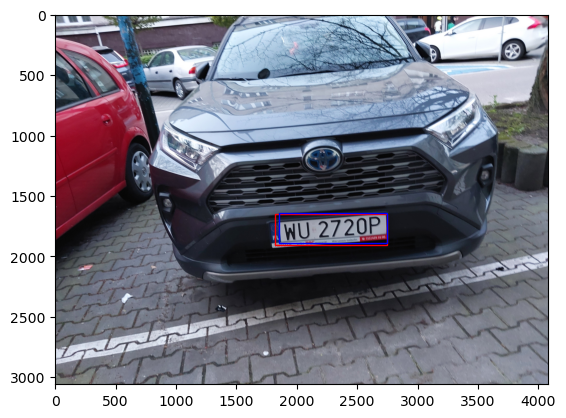

In [14]:
image = mpimg.imread(path)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a Rectangle patch
rect1 = patches.Rectangle((cords[0], cords[1]), cords[2]-cords[0], cords[3]-cords[1], linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((cords2[0], cords2[1]), cords2[2]-cords2[0], cords2[3]-cords2[1], linewidth=1, edgecolor='b', facecolor='none')

# Add the patches to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

### Funkcja IOU 

Definiujemy funkcję obliczającą Intersection Over Union.

In [15]:
def calculate_iou(boxa, boxb):
    """
    Calculate the Intersection over Union (IOU) between two bounding boxes.
    
    Args:
        box1 (tuple): (x1, y1, x2, y2) coordinates of the first bounding box.
        box2 (tuple): (x1, y1, x2, y2) coordinates of the second bounding box.
        
    Returns:
        float: Intersection over Union (IOU) value.
    """
    x1_min, y1_min, x1_max, y1_max = boxa
    x2_min, y2_min, x2_max, y2_max = boxb
    
    # Calculate the coordinates of the intersection rectangle
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)
    
    # Calculate the area of the intersection
    inter_width = max(0, x_inter_max - x_inter_min + 1)
    inter_height = max(0, y_inter_max - y_inter_min + 1)
    intersection_area = inter_width * inter_height
    
    # Calculate the areas of the bounding boxes
    boxa_area = (x1_max - x1_min + 1) * (y1_max - y1_min + 1)
    boxb_area = (x2_max - x2_min + 1) * (y2_max - y2_min + 1)
    
    # Calculate the area of union
    union_area = boxa_area + boxb_area - intersection_area
    
    # Calculate and return IOU
    iou = intersection_area / union_area
    return iou

In [16]:
result = calculate_iou(cords, cords2)
print(result)

0.8868497317701838


In [17]:
def get_cords(results):
    cords = results[0].boxes[0].xyxy.tolist()
    x1, y1, x2, y2 = cords[0]
    return x1, y1, x2, y2

Obliczamy IOU dla wszystkich obrazów w zbiorze danych.

In [18]:
lista = []
for i in joined_df.index:
    path = joined_df['filename'][i]
    results = model(path)
    if len(results[0]) != 0:
        cords = get_cords(results)
        cords2 = tuple(joined_df.loc[i, columns_to_extract])
        iou_result = calculate_iou(cords, cords2)
        lista.append(iou_result)
    else:
        lista.append(None)

image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence001.jpg: 640x640 1 license_plate, 121.4ms
Speed: 6.0ms preprocess, 121.4ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence002.jpg: 640x640 1 license_plate, 77.5ms
Speed: 5.6ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence003.jpg: 640x640 1 license_plate, 60.3ms
Speed: 4.5ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_photos\licence004.jpg: 640x640 (no detections), 105.2ms
Speed: 5.1ms preprocess, 105.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 C:\Users\macie\Desktop\Studia\Semestr 4\Projekt Indywidualny\my_hq_ph

In [19]:
joined_df['yolo_iou'] = lista
joined_df.head(15)

,filename,xmin,ymin,xmax,ymax,yolo_iou
0,my_hq_photos/licence001.jpg,1528.90,1727.70,2460.9,1925.3,0.880660
1,my_hq_photos/licence002.jpg,1848.10,1644.90,2744.1,1891.6,0.886850
2,my_hq_photos/licence003.jpg,1146.60,1981.70,1468.2,2083.0,0.866241
3,my_hq_photos/licence004.jpg,1272.40,1564.47,1540.1,1641.8,NaN
4,my_hq_photos/licence005.jpg,773.40,2522.40,1464.8,2772.7,0.901539
5,my_hq_photos/licence006.jpg,994.20,2741.40,1810.0,2982.8,0.780894
6,my_hq_photos/licence007.jpg,877.60,3293.10,1760.6,3504.1,0.861653
7,my_hq_photos/licence008.jpg,689.30,3045.20,1623.5,3262.3,0.829451
8,my_hq_photos/licence009.jpg,860.70,2960.70,1752.0,3173.8,0.887685
9,my_hq_photos/licence010.jpg,903.90,2854.00,1789.6,3129.6,0.787280


In [20]:
joined_df['yolo_iou'].describe()

count    301.000000
mean       0.901079
std        0.064640
min        0.381840
25%        0.875944
50%        0.916312
75%        0.945771
max        0.990734
Name: yolo_iou, dtype: float64

Definiujemy Jakość detekcji
Jeżeli wartość IOU wynosi:
- 0.9 < IOU < 1 - doskonała detekcja
- 0.7 < IOU < 0.9 - dobra detekcja
- IOU < 0.7 - fatalna detekcja

In [21]:
no_results = len(joined_df['yolo_iou'])
no_greats = (joined_df['yolo_iou'] > 0.9).sum()
print("Procent doskonałych detekcji: {:.2f}%".format(no_greats*100/no_results))
no_decent = ((0.7 < joined_df['yolo_iou']) & (joined_df['yolo_iou'] < 0.9)).sum()
print("Procent dobrych detekcji: {:.2f}%".format(no_decent *100/no_results))
no_bad = (joined_df['yolo_iou'] < 0.7).sum()
print("Procent fatalnych detekcji: {:.2f}%".format(no_bad*100/no_results))
no_nans = joined_df['yolo_iou'].isna().sum()
print("Procent bez detekcji: {:.2f}%".format(no_nans*100/no_results))

Procent doskonałych detekcji: 60.00%
Procent dobrych detekcji: 36.45%
Procent fatalnych detekcji: 0.65%
Procent bez detekcji: 2.90%


Wnioski:

- Średnia wartość IOU wynosząca 0.901 wskazuje, że detekcje są ogólnie bardzo dokładne. Jest to blisko maksymalnej wartości 1, co oznacza, że przeciętne granice wykrytych obiektów dobrze pokrywają się z rzeczywistymi granicami.

- Odchylenie standardowe 0.065 jest stosunkowo niskie, co sugeruje, że wartości IOU są skonsolidowane wokół średniej. Detekcje są więc stabilne i przewidywalne.

**Doskonałe detekcje** (60.00%): Zdecydowana większość detekcji jest doskonała, co oznacza, że model działa bardzo skutecznie.
**Dobre detekcje** (36.45%): Kolejna duża część detekcji jest dobra, co dalej potwierdza wysoką skuteczność modelu.
**Fatalne detekcje** (0.65%): Bardzo niski procent detekcji jest fatalny, co jest pozytywne, ale wymaga zidentyfikowania przyczyn tych niepowodzeń.
**Brak detekcji** (2.90%): Stosunkowo niski procent brakujących detekcji, co jest również pozytywnym wskaźnikiem, ale warto zbadać te przypadki, aby zminimalizować błędy.

## InceptionRasNetV2

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [23]:
model = tf.keras.models.load_model('./object_detection.keras')
print('Model loaded Sucessfully')

Model loaded Sucessfully


C:\Users\macie\anaconda3\envs\tf_cpu\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 496 variables whereas the saved optimizer has 990 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Modfykujemy funkcję obliczającą IOU dla nowego modelu.

In [24]:
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    return image, coords

Obliczamy IOU dla wszystkich obrazów w zbiorze danych.

In [25]:
lista = []
for i in joined_df.index:
    path = joined_df['filename'][i]
    image, coords = object_detection(path)
    if len(results[0]) != 0:
        xmin, xmax,ymin,ymax = coords[0]
        cords = (xmin, ymin, xmax, ymax)
        cords2 = tuple(joined_df.loc[i, columns_to_extract])
        iou_result = calculate_iou(cords, cords2)
        lista.append(iou_result)
    else:
        lista.append(None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [26]:
joined_df['IRasNetv2_iou'] = lista
joined_df.head(15)

,filename,xmin,ymin,xmax,ymax,yolo_iou,IRasNetv2_iou
0,my_hq_photos/licence001.jpg,1528.90,1727.70,2460.9,1925.3,0.880660,0.631515
1,my_hq_photos/licence002.jpg,1848.10,1644.90,2744.1,1891.6,0.886850,0.394391
2,my_hq_photos/licence003.jpg,1146.60,1981.70,1468.2,2083.0,0.866241,0.000000
3,my_hq_photos/licence004.jpg,1272.40,1564.47,1540.1,1641.8,NaN,0.000000
4,my_hq_photos/licence005.jpg,773.40,2522.40,1464.8,2772.7,0.901539,0.000000
5,my_hq_photos/licence006.jpg,994.20,2741.40,1810.0,2982.8,0.780894,0.000000
6,my_hq_photos/licence007.jpg,877.60,3293.10,1760.6,3504.1,0.861653,0.000000
7,my_hq_photos/licence008.jpg,689.30,3045.20,1623.5,3262.3,0.829451,0.000000
8,my_hq_photos/licence009.jpg,860.70,2960.70,1752.0,3173.8,0.887685,0.000000
9,my_hq_photos/licence010.jpg,903.90,2854.00,1789.6,3129.6,0.787280,0.000000


In [27]:
joined_df['IRasNetv2_iou'].describe()

count    310.000000
mean       0.543373
std        0.385955
min       -0.000000
25%        0.000000
50%        0.748905
75%        0.875391
max        0.982833
Name: IRasNetv2_iou, dtype: float64

Tak jak dla poprzedniego modelu definiujemy Jakość detekcji
Jeżeli wartość IOU wynosi:
- 0.9 < IOU < 1 - doskonała detekcja
- 0.7 < IOU < 1 - dobra detekcja
- IOU < 0.7 - fatalna detekcja

In [28]:
no_results = len(joined_df['IRasNetv2_iou'])
no_greats = (joined_df['IRasNetv2_iou'] > 0.9).sum()
print("Procent doskonałych detekcji: {:.2f}%".format(no_greats*100/no_results))
no_decent = ((0.7 < joined_df['IRasNetv2_iou']) & (joined_df['IRasNetv2_iou'] < 0.9)).sum()
print("Procent dobrych detekcji: {:.2f}%".format(no_decent *100/no_results))
no_bad = (joined_df['IRasNetv2_iou'] < 0.7).sum()
print("Procent fatalnych detekcji: {:.2f}%".format(no_bad*100/no_results))
no_nans = joined_df['IRasNetv2_iou'].isna().sum()
print("Procent bez detekcji: {:.2f}%".format(no_nans*100/no_results))

Procent doskonałych detekcji: 18.06%
Procent dobrych detekcji: 36.77%
Procent fatalnych detekcji: 45.16%
Procent bez detekcji: 0.00%


Wnioski:

- Średnia wartość IOU wynosząca 0.543 wskazuje, że ogólna skuteczność modelu jest kiepska. Jest to znacznie niższa wartość w porównaniu do poprzedniego modelu.

- Odchylenie standardowe 0.386 jest stosunkowo wysokie, co sugeruje dużą zmienność w skuteczności detekcji. Wartości IOU są rozproszone, co wskazuje na niestabilność modelu.

**Doskonałe detekcje** (18.06%): Tylko niewielka część detekcji jest doskonała, co wskazuje na ograniczoną skuteczność modelu w precyzyjnym wykrywaniu obiektów.
**Dobre detekcje** (36.77%): Część detekcji jest dobra, ale jest to mniej niż połowa wszystkich detekcji.
**Fatalne detekcje** (45.16%): Duża część detekcji jest fatalna, co wskazuje na poważne problemy z dokładnością modelu.
**Brak detekcji** (0.00%): Model zawsze coś wykrywa, ale często są to wykrycia o niskiej jakości (fatalne detekcje).

# Testowanie OCR (pytesseract)

In [3]:
import pytesseract as pt
import cv2
pt.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

Do przetestowania różnych kofiuguracji pytesseract użyjemy własnoręcznie zrobionych zdjęć z etykietami.

In [30]:
plate_numbers_df = pd.read_json('my_hq_photos/plate_numbers_annot.json')
plate_numbers_df = plate_numbers_df.rename(columns={'file_name': 'filename'})
plate_numbers_df['filename'] = 'my_hq_photos/' + plate_numbers_df['filename']
pytesseract_df = my_df.merge(plate_numbers_df, on='filename')

In [31]:
pytesseract_df.head()

,filename,xmin,ymin,xmax,ymax,license_plate
0,my_hq_photos/licence001.jpg,1528.9,1727.70,2460.9,1925.3,WU2720P
1,my_hq_photos/licence002.jpg,1848.1,1644.90,2744.1,1891.6,WU2720P
2,my_hq_photos/licence003.jpg,1146.6,1981.70,1468.2,2083.0,WU1020E
3,my_hq_photos/licence004.jpg,1272.4,1564.47,1540.1,1641.8,WA8102F
4,my_hq_photos/licence005.jpg,773.4,2522.40,1464.8,2772.7,WU77713


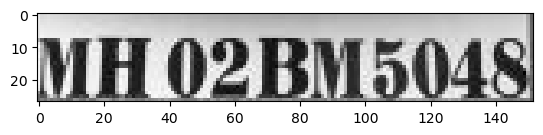

In [32]:
row_index = 88
path = joined_df['filename'][row_index]
img = cv2.imread(path)
columns_to_extract = ['xmin', 'ymin', 'xmax', 'ymax']
pt_cords = tuple(joined_df.loc[row_index, columns_to_extract])
x1, y1, x2, y2 = pt_cords
license_plate_img = img[int(y1):int(y2), int(x1):int(x2)]
gray = cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()

In [33]:
text = pt.image_to_string(gray, config='--psm 7 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
text = text.strip()
print(text)

MH02BM5048


Definiujemy funkcję pytesseract_ocr, która zwraca tekst rozpoznany przez pytesseract.

In [34]:
def pytesseract_ocr(index, config):
    path = pytesseract_df['filename'][index]
    img = cv2.imread(path)
    columns_to_extract = ['xmin', 'ymin', 'xmax', 'ymax']
    pt_cords = tuple(pytesseract_df.loc[index, columns_to_extract])
    x1, y1, x2, y2 = pt_cords
    license_plate_img = img[int(y1):int(y2), int(x1):int(x2)]
    gray = cv2.cvtColor(license_plate_img, cv2.COLOR_BGR2GRAY)
    text = pt.image_to_string(gray, config=config)
    text = text.strip()
    return text

# Metryka Character error rate

Do ewaluacji jakości rozpoznawania tekstu użyjemy metryki CER (Character Error Rate). Jest to metryka używana do oceny jakości rozpoznawania tekstu. Wartość ta jest obliczana jako stosunek liczby błędnie rozpoznanych znaków do liczby wszystkich znaków w tekście. Metryka ta przyjmuje wartości z zakresu [0, 1], gdzie 0 oznacza idealne rozpoznanie, a 1 oznacza całkowity brak rozpoznania.

In [40]:
from cer import calculate_cer

Sprawdzamy CER dla przykładowego obrazu.

In [41]:
#Calculate CER for no config tesseract prediction
row_index = 2
labeled_text = pytesseract_df['license_plate'][row_index]
predicted_text = pytesseract_ocr(row_index, config='--psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
cer = calculate_cer([labeled_text], [predicted_text])
print("text oryginalny: ", labeled_text)
print("text przewidziany: ", predicted_text)
print(cer)

text oryginalny:  WU1020E
text przewidziany:  WU1020E
0.0


Defiinujemy różne konfiguracje dla pytesseract.

In [42]:
#define confings
pt_configs = ["-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6",
              "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 7",
              "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8",
              "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 11",
              "-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 12"]
    
#6    Assume a single uniform block of text.
#7    Treat the image as a single text line.
#8    Treat the image as a single word.
#11    Sparse text. Find as much text as possible in no particular order.
#12    Sparse text with OSD.

Dla każdej konfiguracji przeprowadzamy testy.

In [43]:
col_id = 1
for configuration in pt_configs:
    lista = []
    for i in pytesseract_df.index:
        text = pytesseract_ocr(i, configuration)
        lista.append(text)
    col_name = "pt_prediction_" + str(col_id)
    pytesseract_df[col_name] = lista
    print(f"Finished for {col_name}")
    col_id += 1

Finished for pt_prediction_1
Finished for pt_prediction_2
Finished for pt_prediction_3
Finished for pt_prediction_4
Finished for pt_prediction_5


In [44]:
pytesseract_df.head(15)

,filename,xmin,ymin,xmax,ymax,license_plate,pt_prediction_84,pt_prediction_1,pt_prediction_2,pt_prediction_3,pt_prediction_4,pt_prediction_5
0,my_hq_photos/licence001.jpg,1528.90,1727.70,2460.9,1925.3,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P
1,my_hq_photos/licence002.jpg,1848.10,1644.90,2744.1,1891.6,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P
2,my_hq_photos/licence003.jpg,1146.60,1981.70,1468.2,2083.0,WU1020E,WU1020E,WU1020E,WU1020E,WU1020E,WU1020E,WU1020E
3,my_hq_photos/licence004.jpg,1272.40,1564.47,1540.1,1641.8,WA8102F,WA8T02F,WA8T02F,WA8T02F,WA8T02F,WA8T02F,WA8T02F
4,my_hq_photos/licence005.jpg,773.40,2522.40,1464.8,2772.7,WU77713,WU77713,Y CAROLINA TOYOTA WOLA J713,Y CAROLINA TOYOTA WOLA J713,WU77713,Y CAROLINA TOYOTA WOLA HS4,Y CAROLINA TOYOTA WOLA HS4
5,my_hq_photos/licence006.jpg,994.20,2741.40,1810.0,2982.8,WU8418A,WU8418A,WU8418A,WU8418A,WU8418A,WU84184,WU84184
6,my_hq_photos/licence007.jpg,877.60,3293.10,1760.6,3504.1,WE5220N,WE5220N,WE5220N,WE5220N,WE5220N,WE5220N,WE5220N
7,my_hq_photos/licence008.jpg,689.30,3045.20,1623.5,3262.3,WU1395P,WU1395P,WU1395P,WU1395P,WU1395P,WU1395P,WU1395P
8,my_hq_photos/licence009.jpg,860.70,2960.70,1752.0,3173.8,KK81638,KK81638,KK81638,KK81638,KK81638,KK81638,KK81638
9,my_hq_photos/licence010.jpg,903.90,2854.00,1789.6,3129.6,WU8616J,WU86167,WU8616,WU8616,WU86167,WU8616,WU8616


In [45]:
for i in range(1, 6):
    col_name = "pt_prediction_" + str(i)
    lista = []
    for j in pytesseract_df.index:
        cer = calculate_cer([pytesseract_df['license_plate'][j]], [pytesseract_df[col_name][j]])
        lista.append(cer)
    col_name = "cer_" + str(i)
    pytesseract_df[col_name] = lista

In [46]:
pytesseract_df.head(15)

,filename,xmin,ymin,xmax,ymax,license_plate,pt_prediction_84,pt_prediction_1,pt_prediction_2,pt_prediction_3,pt_prediction_4,pt_prediction_5,cer_1,cer_2,cer_3,cer_4,cer_5
0,my_hq_photos/licence001.jpg,1528.90,1727.70,2460.9,1925.3,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,0.000000,0.000000,0.000000,0.000000,0.000000
1,my_hq_photos/licence002.jpg,1848.10,1644.90,2744.1,1891.6,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,WU2720P,0.000000,0.000000,0.000000,0.000000,0.000000
2,my_hq_photos/licence003.jpg,1146.60,1981.70,1468.2,2083.0,WU1020E,WU1020E,WU1020E,WU1020E,WU1020E,WU1020E,WU1020E,0.000000,0.000000,0.000000,0.000000,0.000000
3,my_hq_photos/licence004.jpg,1272.40,1564.47,1540.1,1641.8,WA8102F,WA8T02F,WA8T02F,WA8T02F,WA8T02F,WA8T02F,WA8T02F,0.142857,0.142857,0.142857,0.142857,0.142857
4,my_hq_photos/licence005.jpg,773.40,2522.40,1464.8,2772.7,WU77713,WU77713,Y CAROLINA TOYOTA WOLA J713,Y CAROLINA TOYOTA WOLA J713,WU77713,Y CAROLINA TOYOTA WOLA HS4,Y CAROLINA TOYOTA WOLA HS4,1.000000,1.000000,0.000000,1.000000,1.000000
5,my_hq_photos/licence006.jpg,994.20,2741.40,1810.0,2982.8,WU8418A,WU8418A,WU8418A,WU8418A,WU8418A,WU84184,WU84184,0.000000,0.000000,0.000000,0.142857,0.142857
6,my_hq_photos/licence007.jpg,877.60,3293.10,1760.6,3504.1,WE5220N,WE5220N,WE5220N,WE5220N,WE5220N,WE5220N,WE5220N,0.000000,0.000000,0.000000,0.000000,0.000000
7,my_hq_photos/licence008.jpg,689.30,3045.20,1623.5,3262.3,WU1395P,WU1395P,WU1395P,WU1395P,WU1395P,WU1395P,WU1395P,0.000000,0.000000,0.000000,0.000000,0.000000
8,my_hq_photos/licence009.jpg,860.70,2960.70,1752.0,3173.8,KK81638,KK81638,KK81638,KK81638,KK81638,KK81638,KK81638,0.000000,0.000000,0.000000,0.000000,0.000000
9,my_hq_photos/licence010.jpg,903.90,2854.00,1789.6,3129.6,WU8616J,WU86167,WU8616,WU8616,WU86167,WU8616,WU8616,0.142857,0.142857,0.142857,0.142857,0.142857


In [47]:
pytesseract_df.describe()

,xmin,ymin,xmax,ymax,cer_1,cer_2,cer_3,cer_4,cer_5
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,1044.526235,2322.648706,1713.944235,2515.285882,0.464076,0.446008,0.240126,0.505672,0.510042
std,368.805238,554.849346,383.753823,597.614679,0.453620,0.442894,0.330196,0.430050,0.445553
min,295.400000,333.870000,534.600000,391.730000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,836.300000,2137.300000,1537.300000,2310.900000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,957.400000,2432.200000,1683.360000,2642.500000,0.250000,0.285714,0.125000,0.428571,0.428571
75%,1213.700000,2703.700000,1842.900000,2920.800000,1.000000,1.000000,0.285714,1.000000,1.000000
max,2154.900000,3293.100000,2763.600000,3504.100000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
for i in range(1, 6):
    col_name = "cer_" + str(i)
    mean_cer = np.mean(pytesseract_df[col_name])
    print(f"Mean CER for {col_name}: {mean_cer}")

Mean CER for cer_1: 0.4640756302521009
Mean CER for cer_2: 0.4460084033613445
Mean CER for cer_3: 0.24012605042016805
Mean CER for cer_4: 0.5056722689075631
Mean CER for cer_5: 0.5100420168067227


Wnioski:
Najlepsze wyniki dla naszego zbioru danych uzyskaliśmy dkla konfigruacji nr 3.

-- psm 8    Treat the image as a single word.

Dla najlepszej konfiguracji Pytesseract i dla najlepszego modelu YOLO przeprowadzamy dodatkowy test na pliku wideo.

In [4]:
model = YOLO('runs/detect/train9/weights/best.onnx')

# Load the video
cap = cv2.VideoCapture('lp_video.mp4')

# Get video details
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create a VideoWriter object
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc('X','2','6','4'), 10, (frame_width,frame_height))

label_list = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # Perform inference
        results = model(frame)

        # Check if results are not empty
        if len(results[0]) > 0:
            # Draw bounding boxes and labels on the frame
            for result in results:
                coords = result[0].boxes[0].xyxy.tolist()[0]
                x1, y1, x2, y2 = map(int, coords)  # Convert coordinates to integers
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                label = pt.image_to_string(frame[y1:y2, x1:x2], config="-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8").strip()
                label_list.append(label)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

            # Write the frame into the output file
            out.write(frame)

        # Quit if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()

Loading runs\detect\train9\weights\best.onnx for ONNX Runtime inference...
0: 640x640 (no detections), 65.8ms
Speed: 7.0ms preprocess, 65.8ms inference, 2205.6ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 55.9ms
Speed: 4.0ms preprocess, 55.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 53.9ms
Speed: 5.5ms preprocess, 53.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 57.7ms
Speed: 6.5ms preprocess, 57.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 55.0ms
Speed: 5.0ms preprocess, 55.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 58.3ms
Speed: 3.5ms preprocess, 58.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
0: 640x640 (no detections), 55.2ms
Speed: 5.6ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640

W celu dodatkowej dokładności możemy sprawdzić najczęściej występujące etykiety.

In [5]:
print(label_list)

['BWO251', '', 'RY02505', 'BAV02501', 'BW022058', 'J', 'RAN020059', 'RW025059', 'QS', 'BW02900', 'A200', '', '', 'TOR', 'IWU02905', 'P', 'P', 'BW025099', 'A', 'S', 'RWU02005', '', 'A020', 'W02', '7', 'QS', 'QOS', 'W020', '070021', 'D', 'SS', 'EW02505', 'S', 'WU02905', 'TWU02505', 'UEA', 'WO', 'BOC', 'ALE', 'WU02505', 'B50', 'AWU02595', 'PW', 'IWU0250S', 'AWU02505', 'WUO7SCS', 'WU0250S', '1WU0250S', 'PWU0250S', 'WU0250S', 'AWUHODSO3', 'BW072505', 'ISAS', 'S', 'SWUO2SOS', 'WU02505', 'A', 'BWUOZ50', 'PWU0250S', '1WU0250S', 'AWU0250S', '1WU0250S', 'CTS', 'WU02505', 'B7005', 'PWURO2SOS', 'HWU20250S', 'BWU0250S', 'NS', 'BWU02505', 'BK0250S', 'WU0250S', 'PWU02505', 'BSO2SO', 'BAUS', 'WU02505', 'BWU0250S', '1WU0250S', 'BWU0250S', 'AWU0250S', 'PAUO2505', 'WU0250S', 'EWU0250S', 'M30250S', 'O75', 'AAU0250S', 'PWU0250S', 'PWU0250S', 'WU0250S', 'PUO250S', 'ARRERTRD', 'MOSOS', 'WU0250S', 'F4J0250S', 'PWU02505S', 'FU0250S', 'PWU0250S', 'PWU0250S', 'F0250S', 'FU0250S', 'PU0250S', '4J0250S', '430250S',

In [6]:
from collections import Counter
label_count = Counter(label_list)
most_common_label = label_count.most_common(2)
print(most_common_label)

[('PWU0250S', 7), ('WU0250S', 6)]


### Podsumowanie
Model detekcji obiektów działa poprawnie, ale wciąż jest pole do poprawy. 

- W zależności od przypadku użycia możemy wykorzystać większy model YOLOv8, jednak będzie on wymagał więcej zasobów obliczeniowych.
- Zwiększenie ilości danych treningowych może poprawić skuteczność modelu.
- Poprawa jakości obrazów wejściowych może również pomóc w poprawie skuteczności modelu. (W projekcie wykorzystano zdjęcia z telefonu komórkowego)

Model OCR (Pytesseract) działa dobrze tylko, gdy obrazy są dobrej jakości, tekst jest czytelny i nie ma dużego zaszumienia. Ponadto nie może być odchylenia w kącie obrazu. W przeciwnym razie model nie będzie działał poprawnie.

### Spostrzeżenia:

- Annotacje zdjęć nie powinny zawierać całej tablicy rejestracyjnej, ale samo pole z numerem rejestracyjnym.
- W przypadku zdjęć z tablicami rejestracyjnymi, które są zbyt małe (zbyt daleko), model może mieć problem z ich rozpoznaniem.

### Sugestie:
- Należałoby przetestować inne gotowe modele OCR, aby sprawdzić, który z nich działa najlepiej dla naszego zbioru danych.
- Należałoby przetestować gotowe modele detekcji obiektów przystosowane do detekcji tablic rejestracyjnych w celu porównanie jego skutezczności z naszym modelem.
